In [1]:
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from nilearn import plotting as ni_plt

import json, pickle
import pandas as pd
from tqdm import tqdm
import sys, os, pdb

from src.data_utils import ECoG_Data
import src.manifold_u as mu
import importlib
importlib.reload(mu)
import fig_utils as figu
importlib.reload(figu)


plt.style.use(['science', 'retro'])
sns.set_style("ticks")
plt.rcParams.update({"font.size": 10})

In [2]:
filepath = '/home/zsteineh/research_projects/NaturalisticNeuralManifolds/experiment_params/'
file_name = 'exp_params_nat_pca.json'
try:
    json_filename = filepath + file_name
except IndexError:
    raise SystemExit(f"Usage: {sys.argv[0]} <json file of experiment parameters>")
with open(json_filename) as f:
    exp_params = json.load(f)
print(exp_params['comment'])

Param file for running PCA pipeline on naturalistic data


In [3]:
movement_colors, day_colors, participant_colors, exp_class_colors, exp_participant_colors, freq_colors = mu.get_all_colors()

In [4]:
freq_bands = exp_params["freq_bands"]
class_dict = exp_params["class_dict"]
class_dict = {int(cur_key) - 1: val for cur_key, val in class_dict.items() if val != 'rest'}
class_color = exp_params["class_color"]
class_color = {int(cur_key): val for cur_key, val in class_color.items()}

proj_mat_sp = exp_params["sp"] + exp_params["dataset"] + exp_params["experiment_folder"]

percent_threshold = 0.8
pats_ids_in = exp_params["pats_ids_in"]
days_tested = exp_params["test_day"]

cur_freq = 'Beta'
cur_freq_ind = 2
freq_red_dim = 10

In [5]:
data_slice_fig_path = '/home/zsteineh/research_projects/neural_manifolds/scripts/final_scripts/journal_figures/Q3_data_slice.png'
data_slice = plt.imread(data_slice_fig_path)

In [6]:
cross_day_pas = pickle.load(open(proj_mat_sp + 'freq_cross_day_pas.pkl', 'rb'))
print(cross_day_pas.keys())

cross_day_nd_df = pd.read_csv(proj_mat_sp + 'freq_cross_day_nd_df.csv')
print(cross_day_nd_df)

cross_day_lag_nd_df = pd.read_csv(proj_mat_sp + 'freq_cross_day_lagged_nd_df.csv')
print(cross_day_lag_nd_df)

dict_keys(['LFO', 'Alpha', 'Beta', 'Low Gamma', 'Gamma', 'High Gamma'])


         Unnamed: 0   Frequency Participant Movement Day Comparison  \
0                 0         LFO         P01     left         3 vs 4   
1                 1         LFO         P01     left         3 vs 5   
2                 2         LFO         P01     left         3 vs 6   
3                 3         LFO         P01     left         3 vs 7   
4                 4         LFO         P01     left         4 vs 5   
...             ...         ...         ...      ...            ...   
1670875         475  High Gamma         P12       up         4 vs 6   
1670876         476  High Gamma         P12       up         4 vs 7   
1670877         477  High Gamma         P12       up         5 vs 6   
1670878         478  High Gamma         P12       up         5 vs 7   
1670879         479  High Gamma         P12       up         6 vs 7   

         Neural Dissimilarity  
0                    0.259786  
1                    0.218220  
2                    0.187073  
3                  

In [7]:
null_data_pa = np.load(exp_params['cross_days_null_pa_lp'] + 'TME_null_pas.npy', allow_pickle=True)
# null_data_pa = np.array(null_data_pa)
# print(null_data_pa.shape)

In [8]:
all_sbjs_pca = []
for f, freq in enumerate(freq_bands):
    cur_pca = np.load(proj_mat_sp + freq + '_pca_objects.npy', allow_pickle=True)
    all_sbjs_pca.append(cur_pca)
all_sbjs_pca = np.array(all_sbjs_pca)
print(all_sbjs_pca.shape)

(6, 12, 5, 5)


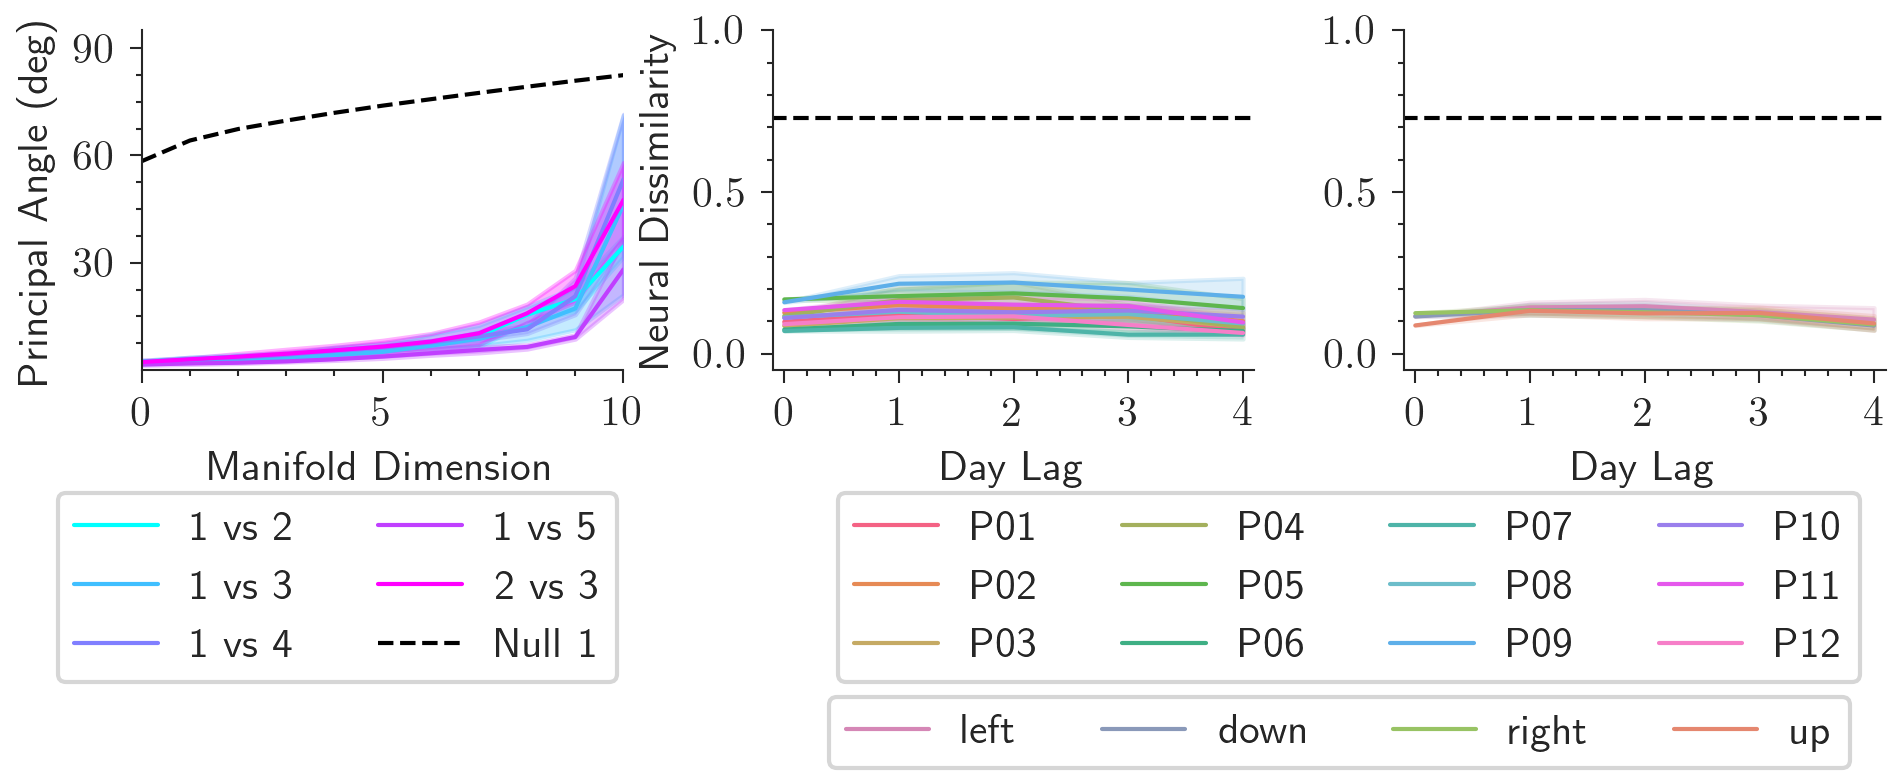

In [9]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, 
                    ncols=3, 
                    figsize=(7.5, 1.5), dpi = 300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.31, hspace=None)

comps_to_plot = [0,1,2,3,4]
days_tested = exp_params["test_day"]
days_tested = [str(int(d) - 2) for d in days_tested]

null_pa = np.array(null_data_pa[0][0])
signf_null_pas = np.squeeze(np.percentile(np.mean(null_pa, axis=0), 1, axis=0).mean(axis=2))
figu.plot_PAs(ax0, 
            days_tested, 
            comps_to_plot, 
            np.transpose(np.expand_dims(cross_day_pas[cur_freq], axis=0), (2, 0, 1, 3, 4)), 
            null_data_pa,
            null_sig_pas = signf_null_pas,
            red_dim = freq_red_dim,
            fill_between = True)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles=handles, labels=labels, bbox_to_anchor=[1.03, -0.3], frameon=True, ncol=2)


cur_freq_lag = cross_day_lag_nd_df[(cross_day_lag_nd_df['Frequency'] == cur_freq)]
sigf_val = mu.calc_sumed_significance(cross_day_nd_df)
sns.lineplot(x="Day Lag", 
                y="Neural Dissimilarity", 
                hue = "Participant", 
                data=cur_freq_lag,
                ax=ax1,
                palette=participant_colors,
                )
ax1.hlines(sigf_val, -0.5, 4.1, linestyles="dashed", color="black")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_xticks([0, 1, 2, 3, 4])
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles[1:], labels=labels[1:], bbox_to_anchor=[2.3, -0.3], frameon=True, ncol=4)
# ax1.legend()
# ax1.set_title("A) Manifold Dissimilarity Across\nDays for Each Participant")
ax1.set_xlim([-0.1, 4.1])
ax1.set_ylim(-0.05, 1)

sns.lineplot(x="Day Lag", 
                y="Neural Dissimilarity", 
                hue = "Movement", 
                data=cur_freq_lag,
                ax=ax2,
                palette=movement_colors,
                )
ax2.hlines(sigf_val, -0.5, 4.1, linestyles="dashed", color="black")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xticks([0, 1, 2, 3, 4])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles[1:], labels=labels[1:], bbox_to_anchor=[0.97, -0.9], frameon=True, ncol=4)
ax2.set_xlim([-0.1, 4.1])
ax2.set_ylim(-0.05, 1)
ax2.set_ylabel('')

plt.savefig("/home/zsteineh/research_projects/NaturalisticNeuralManifolds/figures/saved_figures/cross_days_results.svg", format="svg")
plt.show()

### Get the Reporting Numbers

In [10]:
avg_pas = np.nanmean(cross_day_pas['Beta'], axis=(0, 1, 2))
std_pas = np.nanstd(cross_day_pas['Beta'], axis=(0, 1, 2))
print("First PA Average: ", avg_pas[0])
print("First PA STD: ", std_pas[0])
print("Last PA Average: ", avg_pas[-1])
print("Last PA STD: ", std_pas[-1])

First PA Average:  2.5298730948802377
First PA STD:  1.5330691046278655
Last PA Average:  46.490099619449495
Last PA STD:  20.166290748973577


In [11]:
avg_pat_nd = cur_freq_lag['Neural Dissimilarity'].mean()
std_pat_nd = cur_freq_lag['Neural Dissimilarity'].std()
print("Average Cross Day Neural Dissimilarity: ", avg_pat_nd)
print("STD Cross Day Neural Dissimilarity: ", std_pat_nd)

Average Cross Day Neural Dissimilarity:  0.11122247159644429
STD Cross Day Neural Dissimilarity:  0.056341246893302006


In [12]:
print("Null 1% Significance:", sigf_val)

Null 1% Significance: 0.7295297760497623


In [13]:
print("0 Day lag average:", cur_freq_lag[cur_freq_lag['Day Lag'] == 0]['Neural Dissimilarity'].mean())
print("0 Day lag std:", cur_freq_lag[cur_freq_lag['Day Lag'] == 0]['Neural Dissimilarity'].std())

print("4 Day lag average:", cur_freq_lag[cur_freq_lag['Day Lag'] == 4]['Neural Dissimilarity'].mean())
print("4 Day lag std:", cur_freq_lag[cur_freq_lag['Day Lag'] == 4]['Neural Dissimilarity'].std())

0 Day lag average: 0.11121525243780045
0 Day lag std: 0.05634151659689964
4 Day lag average: 0.0946840856500163
4 Day lag std: 0.03969863797039512


In [14]:
print(cur_freq_lag.groupby(['Movement'])['Neural Dissimilarity'].mean())
print(cur_freq_lag.groupby(['Movement'])['Neural Dissimilarity'].std())


Movement
down     0.115451
left     0.116031
right    0.125605
up       0.087713
Name: Neural Dissimilarity, dtype: float64
Movement
down     0.051931
left     0.060394
right    0.057918
up       0.046786
Name: Neural Dissimilarity, dtype: float64


## ROI Contrib Examples

In [15]:
exp_params['test_day'] = 'last'
manifold_ECoG_data = ECoG_Data(exp_params, proj_mat_sp)
roi_centroids = manifold_ECoG_data.roi_centroids

Determining ROIs


  0%|          | 0/12 [00:00<?, ?it/s]

ROIs found
Number of ROIs:  311
loading steve data
Pulling out last for test day


  8%|▊         | 1/12 [00:08<01:35,  8.65s/it]

loading steve data
Pulling out last for test day


 17%|█▋        | 2/12 [00:11<01:09,  6.92s/it]

loading steve data
Pulling out last for test day


 25%|██▌       | 3/12 [00:18<01:02,  6.94s/it]

loading steve data
Pulling out last for test day


 33%|███▎      | 4/12 [00:22<00:47,  5.98s/it]

loading steve data
Pulling out last for test day


 42%|████▏     | 5/12 [00:25<00:36,  5.27s/it]

loading steve data
Pulling out last for test day


 50%|█████     | 6/12 [00:36<00:41,  6.93s/it]

loading steve data
Pulling out last for test day


 58%|█████▊    | 7/12 [00:44<00:35,  7.13s/it]

loading steve data
Pulling out last for test day


 67%|██████▋   | 8/12 [00:56<00:34,  8.71s/it]

loading steve data
Pulling out last for test day


 75%|███████▌  | 9/12 [01:01<00:22,  7.41s/it]

loading steve data
Pulling out last for test day


 83%|████████▎ | 10/12 [01:15<00:19,  9.52s/it]

loading steve data
Pulling out last for test day


 92%|█████████▏| 11/12 [01:35<00:12, 12.64s/it]

loading steve data
Pulling out last for test day


100%|██████████| 12/12 [01:58<00:00,  9.86s/it]


Data loaded!


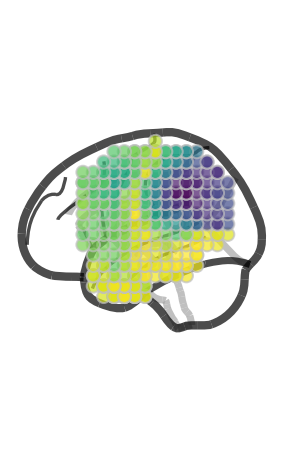

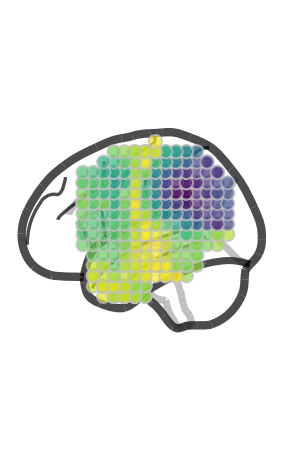

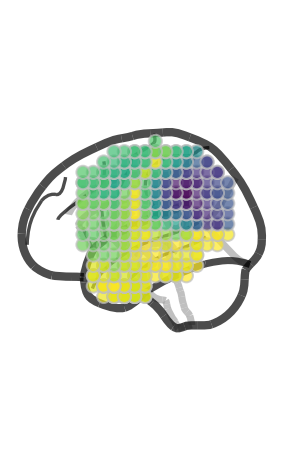

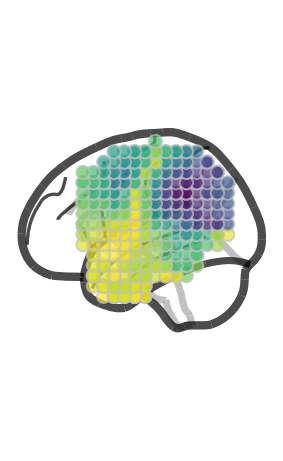

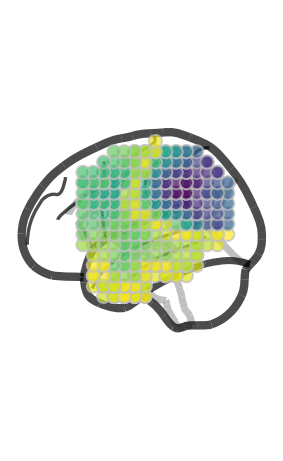

In [16]:
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.rcParams.update({"font.size": 10})
plt.tight_layout()

# left PCs day 1
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,9,0,1]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
plt.show()

# day2 PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,9,1,1]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
plt.show()

# day3 PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,9,2,1]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
plt.show()

# day4 PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,9,3,1]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
plt.show()

# day5 PCS
fig, axes = plt.subplots(figsize=(1.5, 2), dpi=300)
plt.tight_layout()
ax1 = axes
ex_pca = all_sbjs_pca[cur_freq_ind,9,4,1]
first_component = ex_pca.components_[0,:]
df_elec_pos = roi_centroids[0]
figu.plot_roi_contribs(ax1, first_component, df_elec_pos, node_size=10, colorbar=False)
plt.show()